<a href="https://colab.research.google.com/github/rajalingam24/Emotion-Detection/blob/main/Approach2_Resnet_Emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
                                  

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/Colab file/fer2013.csv'

df = pd.read_csv(dataset_path)

df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

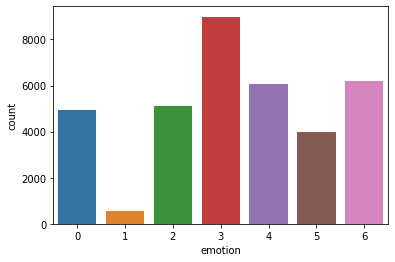

In [ ]:
import seaborn as sns
sns.countplot(data=df, x = 'emotion')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten,Dropout, MaxPooling2D, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


test_datagen = ImageDataGenerator()

In [ ]:
image_size=(48,48)

# Data Loading and Pre-Processing Functionalities

def load_dataset():
    data = pd.read_csv(dataset_path)
    data = (data[data['pixels'].notnull()])
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        face = np.stack((face,)*3, -1)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    #faces = np.expand_dims(faces, -1)
    emotions = (data['emotion'])#.values
    return faces, emotions
 
def preprocess_data(x):
    x = x.astype('float32')
    x = x / 255.0
    return x

In [ ]:
#Data Augumentation
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        shear_range = 10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

faces, emotions = load_dataset()
faces = preprocess_data(faces)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)

In [ ]:
import tensorflow as tf

base_model=tf.keras.applications.ResNet50()

102973440/102967424 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
base_model=tf.keras.applications.ResNet50(input_shape=(224,224,3),include_top=False)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable=False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
'''from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense, GlobalAveragePooling2D
transfer_model=Sequential([base_model,
                          GlobalAveragePooling2D(),
                          Dense(512,activation='relu'),
                          Dense(7,activation='softmax')])
transfer_model.summary()
'''

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1, 1, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 3591      
Total params: 3,757,255
Trainable params: 528,391
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
transfer_model=Sequential([base_model,
                          GlobalAveragePooling2D(),
                          Dense(1024,activation='relu'),
                          Dense(512,activation='relu'),
                          Dense(128,activation='relu'),
                          Dense(7,activation='softmax')])

In [ ]:
transfer_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
from tensorflow.keras.utils import to_categorical
batch_size = 64
num_epochs = 100
history = transfer_model.fit(data_generator.flow(Xtrain, to_categorical(Ytrain)), 
                    steps_per_epoch = int (len(Xtrain) / batch_size), 
                    epochs = num_epochs, 
                    validation_data = test_datagen.flow(Xtest, to_categorical(Ytest)), 
                    validation_steps = int (len(Xtest) / batch_size)
                    )

Epoch 1/100
448/448 [==============================] - 52s 44ms/step - loss: 1.8280 - accuracy: 0.2406 - val_loss: 1.8142 - val_accuracy: 0.2436
Epoch 2/100
448/448 [==============================] - 18s 41ms/step - loss: 1.8115 - accuracy: 0.2489 - val_loss: 1.7862 - val_accuracy: 0.2567
Epoch 3/100
448/448 [==============================] - 18s 40ms/step - loss: 1.8021 - accuracy: 0.2477 - val_loss: 1.7964 - val_accuracy: 0.2606
Epoch 4/100
448/448 [==============================] - 18s 40ms/step - loss: 1.7903 - accuracy: 0.2600 - val_loss: 1.7730 - val_accuracy: 0.2589
Epoch 5/100
448/448 [==============================] - 18s 40ms/step - loss: 1.7813 - accuracy: 0.2679 - val_loss: 1.7728 - val_accuracy: 0.2653
Epoch 6/100
448/448 [==============================] - 18s 40ms/step - loss: 1.7752 - accuracy: 0.2655 - val_loss: 1.7564 - val_accuracy: 0.2771
Epoch 7/100
448/448 [==============================] - 18s 40ms/step - loss: 1.7652 - accuracy: 0.2685 - val_loss: 1.7527 - val_ac

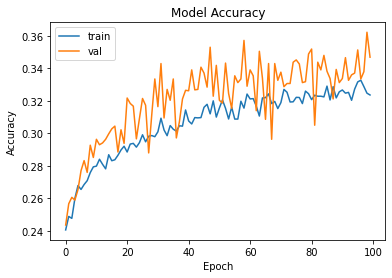

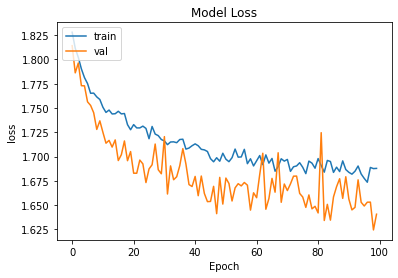

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pd.DataFrame(history.history).tail()

,loss,accuracy,val_loss,val_accuracy
95,1.677531,0.331613,1.649107,0.351283
96,1.673588,0.332659,1.653027,0.333426
97,1.688794,0.328744,1.653093,0.337891
98,1.687627,0.324691,1.624483,0.362165
99,1.687840,0.323573,1.640650,0.346819
